# Template Modeling Workflow - Visualization and kinetic Modeling of enzymatic data

### Imports
Import packages and set global varibales used in this notebook

In [1]:
import os # operating system to work with directories and files
import matplotlib.pyplot as plt # plot data and results
import seaborn as sns # prettier visualization
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver

from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting

from pyenzyme import EnzymeMLDocument # EnzymeML document functionalities

#sns.set(style="whitegrid")

## Select EnzymeML document or the Excel template
Select the EnzymeML document, by changing the path variable accodingly. <br>
The whole EnzymeML document is stored in the enzmldoc variable. <br>

In [2]:
# If the file is a Omex
#round1 = EnzymeMLDocument.fromFile('../../round1/UPO/UPO_with_Model.omex')

# If the file is a
round2 = EnzymeMLDocument.fromTemplate('./Yang_round2_without_conversion.xlsx')

/Users/benjamin/miniforge3/envs/EnzymeML/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/EnzymeML/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/EnzymeML/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/EnzymeML/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/EnzymeML/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/EnzymeML

## Print the Document to get a first overview

In the "Reactants" section you can see which IDs are given to the reactants.
This is for modeling important because we can choose which reactant we want to model.

In [3]:
# With measurements=True in parenthesis we can also print out the initial concentrations 
#round1.printDocument() 
round2.printDocument()

Dehydration of n-octanal oxime  by using aldoxime dehydratases (Oxds) as whole cell biocatalyst
>>> Reactants
	ID: s0 	 Name: n-octanaloxime
	ID: s1 	 Name: octanenitrile
	ID: s2 	 Name: H2O
>>> Proteins
	ID: p0 	 Name: aldoxime dehydratase OxdB with pET28a construct (OxdBWT, wild type)
	ID: p1 	 Name: aldoxime dehydratase OxdB with pET28a construct (OxdB-F289A/L293A mutant)
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Dehydration of n-octanaloxime with OxdB wild type
	ID: r1 	 Name: Dehydration of n-octanaloxime with OxdB mutant
	ID: r2 	 Name: Dehydration of n-octanaloxime with OxdB wild type (with 10 mM C8-nitrile at the beginning)
	ID: r3 	 Name: Dehydration of n-octanaloxime with OxdB mutant (with 10 mM C8-nitrile at the beginning)


In [48]:
round2.vessel_dict

{'v0': Vessel(name='Eppendorf Tube', volume=1000.0, unit='ul', constant=True, meta_id='METAID_V0', id='v0', uri=None, creator_id=None)}

## Visualization of timecourse data
A short visualisation to get a first impression of the data. <br>

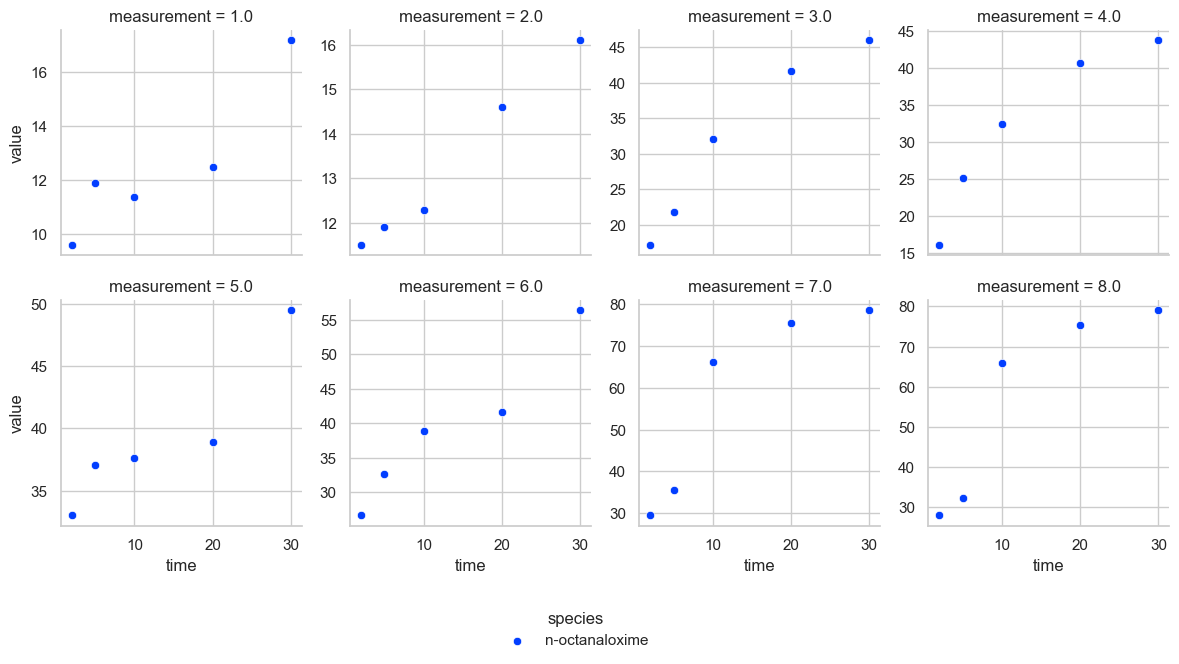

In [4]:
#basic/general settings for Seaborn
sns.set_theme(style="whitegrid", palette ='bright',color_codes=True, context = 'notebook')

#g = round1.visualize(sharey=False, use_names=True, height=3.75)
g2 = round2.visualize(sharey=False, use_names=True, height=3.75)

In [5]:
reactant_id = 's0'
init_conc = 100 # mmole/l
# Exports species specific measurement data (dictionary)
data = round2.exportMeasurementData(species_ids=reactant_id)


# Concatenate data to a single DataFrame
data = pd.concat([meas["data"] for meas in data.values()])
data = np.array_split(data, 8)
data_time = np.array(data[0]["time"])
data_time = np.insert(data_time, 0, 0)

data_s = []
for i in range(len(data)):
    data_s.append(data[i]["s0"])
data_s = np.array(data_s)
data_new = []
for i in range(data_s.shape[0]):
    data_s[i] = [init_conc * (1-conversion/100) for conversion in data_s[i]]
    data_new.append(np.insert(data_s[i], 0, init_conc))
data_new = np.array(data_new)
data_new

array([[100. ,  90.4,  88.1,  88.6,  87.5,  82.8],
       [100. ,  88.5,  88.1,  87.7,  85.4,  83.9],
       [100. ,  82.9,  78.2,  67.9,  58.4,  54. ],
       [100. ,  83.9,  74.8,  67.6,  59.3,  56.2],
       [100. ,  67. ,  62.9,  62.4,  61.1,  50.5],
       [100. ,  73.4,  67.4,  61.1,  58.3,  43.6],
       [100. ,  70.5,  64.4,  33.9,  24.7,  21.6],
       [100. ,  72.1,  67.7,  34.1,  24.6,  21. ]])

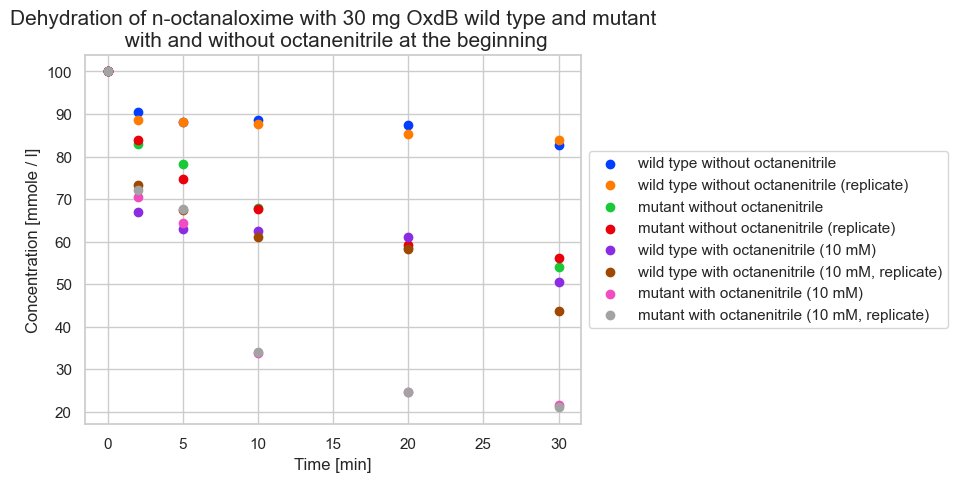

In [44]:
plt.figure()
plt.scatter(data_time, data_new[0], label='wild type without octanenitrile')
plt.scatter(data_time, data_new[1], label='wild type without octanenitrile (replicate)')
plt.scatter(data_time, data_new[2], label='mutant without octanenitrile')
plt.scatter(data_time, data_new[3], label='mutant without octanenitrile (replicate)')
plt.scatter(data_time, data_new[4], label='wild type with octanenitrile (10 mM)')
plt.scatter(data_time, data_new[5], label='wild type with octanenitrile (10 mM, replicate)')
plt.scatter(data_time, data_new[6], label='mutant with octanenitrile (10 mM)')
plt.scatter(data_time, data_new[7], label='mutant with octanenitrile (10 mM, replicate)')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole / l]')
plt.title('Dehydration of n-octanaloxime with 30 mg OxdB wild type and mutant\n with and without octanenitrile at the beginning', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

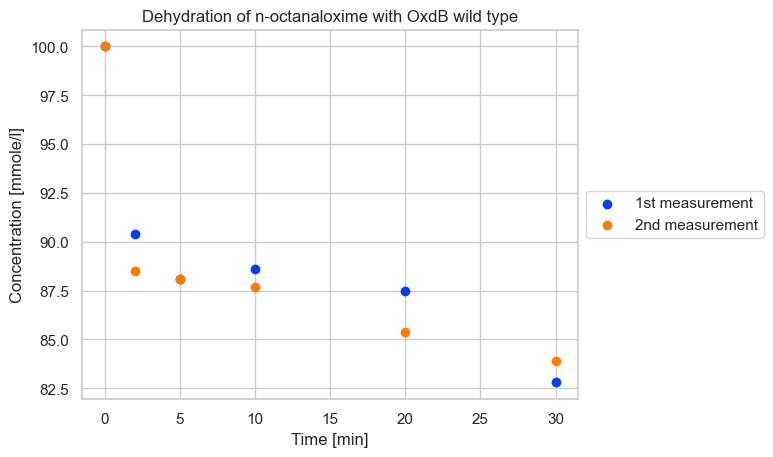

In [7]:
plt.scatter(data_time, data_new[0], label='1st measurement')
plt.scatter(data_time, data_new[1], label='2nd measurement')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB wild type')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

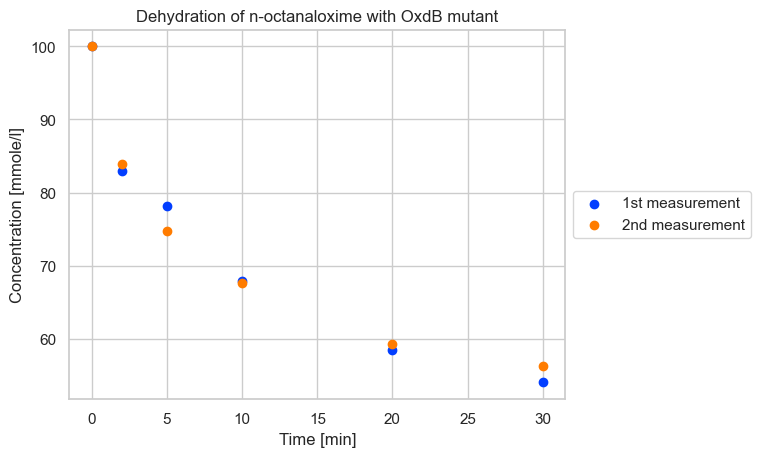

In [8]:
plt.scatter(data_time, data_new[2], label='1st measurement')
plt.scatter(data_time, data_new[3], label='2nd measurement')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB mutant')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

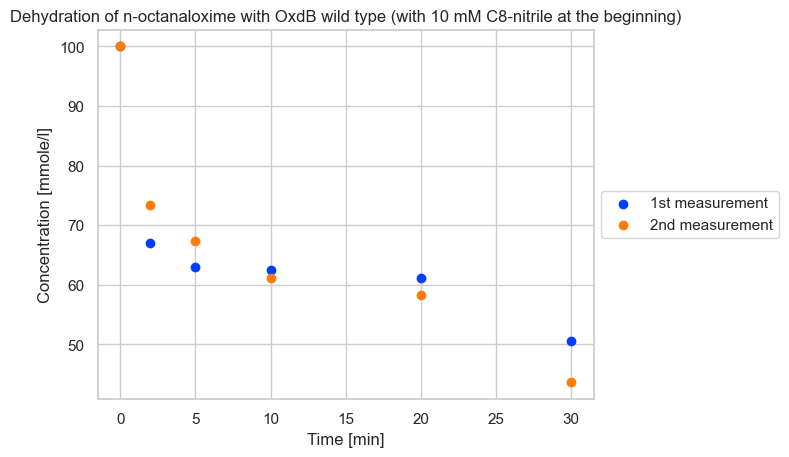

In [9]:
plt.scatter(data_time, data_new[4], label='1st measurement')
plt.scatter(data_time, data_new[5], label='2nd measurement')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB wild type (with 10 mM C8-nitrile at the beginning)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

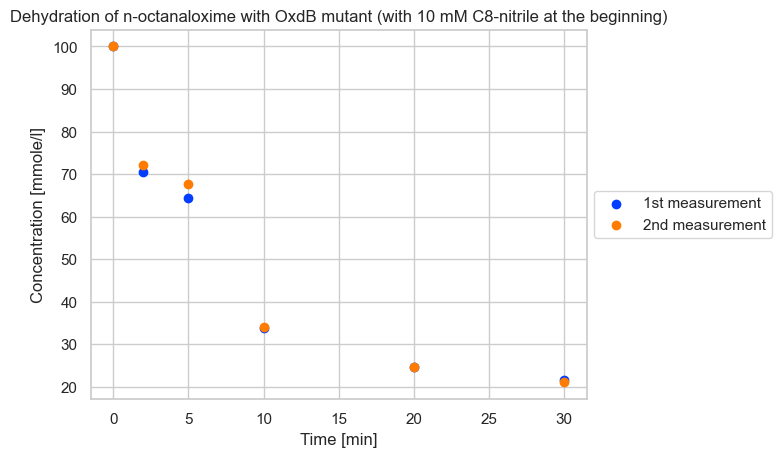

In [10]:
plt.scatter(data_time, data_new[6], label='1st measurement')
plt.scatter(data_time, data_new[7], label='2nd measurement')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB mutant (with 10 mM C8-nitrile at the beginning)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

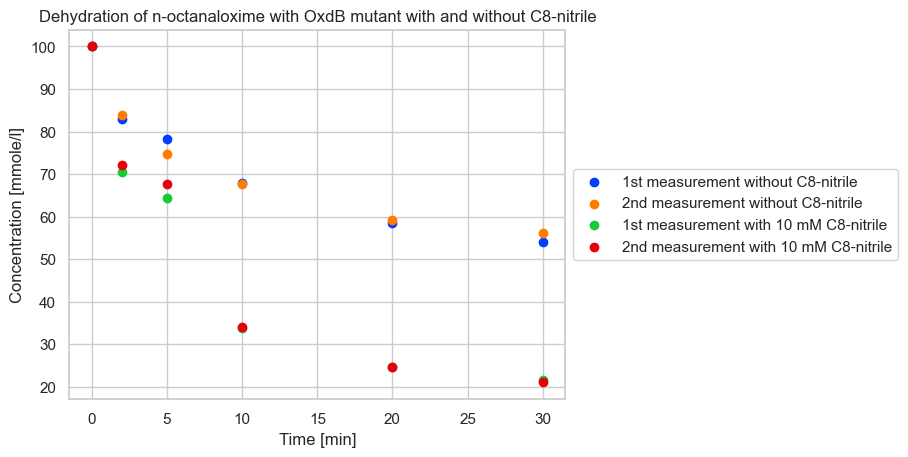

In [11]:
plt.scatter(data_time, data_new[2], label='1st measurement without C8-nitrile')
plt.scatter(data_time, data_new[3], label='2nd measurement without C8-nitrile')
plt.scatter(data_time, data_new[6], label='1st measurement with 10 mM C8-nitrile')
plt.scatter(data_time, data_new[7], label='2nd measurement with 10 mM C8-nitrile')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB mutant with and without C8-nitrile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

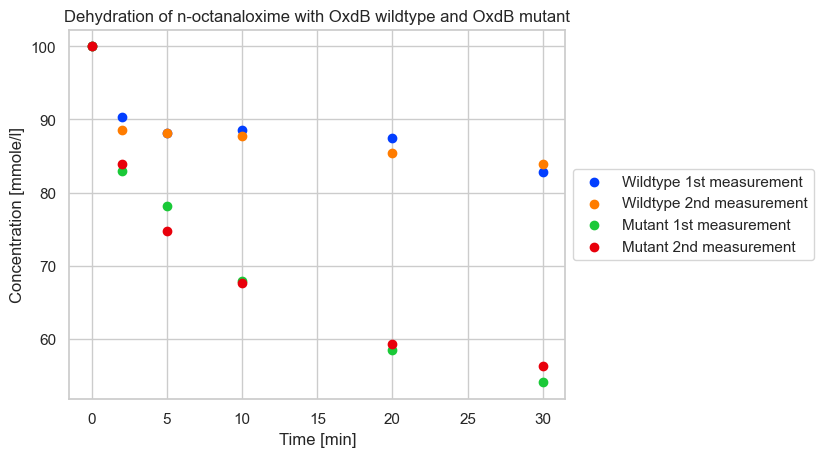

In [12]:
plt.scatter(data_time, data_new[0], label='Wildtype 1st measurement')
plt.scatter(data_time, data_new[1], label='Wildtype 2nd measurement')
plt.scatter(data_time, data_new[2], label='Mutant 1st measurement')
plt.scatter(data_time, data_new[3], label='Mutant 2nd measurement')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB wildtype and OxdB mutant')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

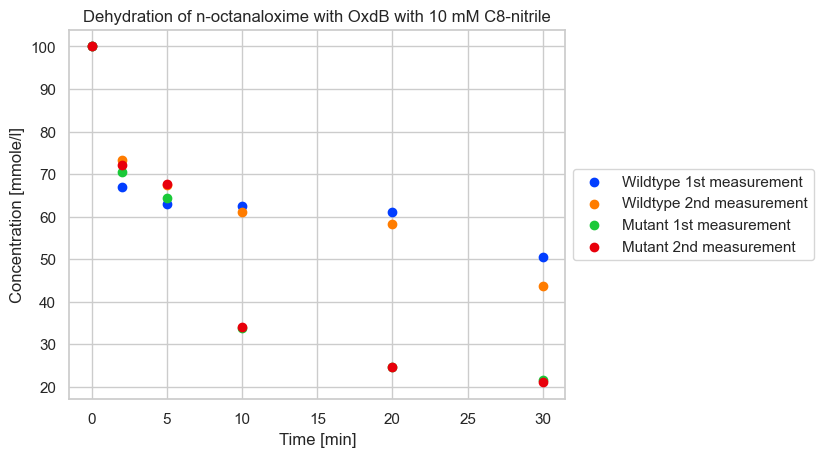

In [13]:
plt.scatter(data_time, data_new[4], label='Wildtype 1st measurement')
plt.scatter(data_time, data_new[5], label='Wildtype 2nd measurement')
plt.scatter(data_time, data_new[6], label='Mutant 1st measurement')
plt.scatter(data_time, data_new[7], label='Mutant 2nd measurement')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB with 10 mM C8-nitrile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

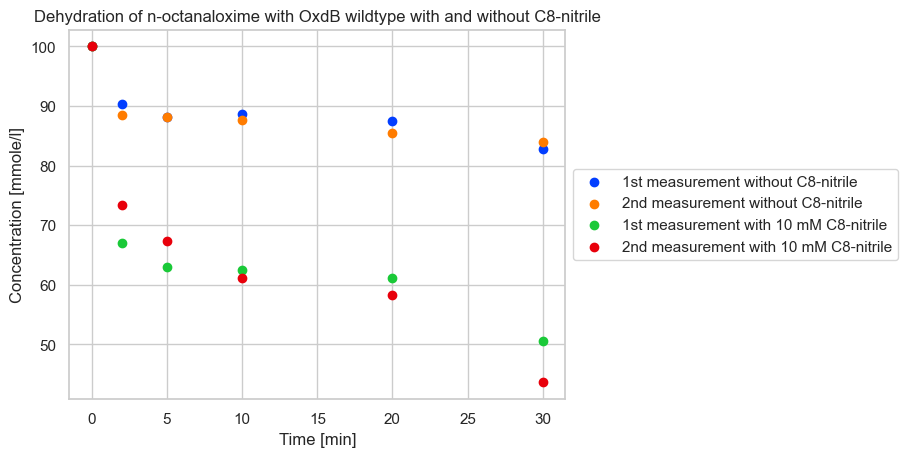

In [14]:
plt.scatter(data_time, data_new[0], label='1st measurement without C8-nitrile')
plt.scatter(data_time, data_new[1], label='2nd measurement without C8-nitrile')
plt.scatter(data_time, data_new[4], label='1st measurement with 10 mM C8-nitrile')
plt.scatter(data_time, data_new[5], label='2nd measurement with 10 mM C8-nitrile')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mmole/l]')
plt.title('Dehydration of n-octanaloxime with OxdB wildtype with and without C8-nitrile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Parameter Estimation and Modeling
#### Data preparation
Convert pandas dataframe from EnzymeML data to numpy arrays. <br>
First select the reactant to model by changing the reactant_id accordingly, see overview above for selction options.<br>
In this example substrate 's0' will be modeled.<br>
##### Choose against which timecourse you want to fit.

In [15]:
data_wildtype = np.array([data_new[0], data_new[1]])
data_mutant = np.array([data_new[2], data_new[3]])
data_wildtype_with_c8 = np.array([data_new[4], data_new[5]])
data_mutant_with_c8 = np.array([data_new[6], data_new[7]])

### Fit data to a system of ODEs
#### Define the ODE functions

In [16]:
def f(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(s'):
    f1 = -vmax * s / (km + s) # S'
    return f1

In [17]:
def michaelis_menten_with_product(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(s'):
    f1 = -vmax * s / (km + s) # S'
    return f1

#### Solve ODE

In [18]:
def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(f, w0, t, args=(params,))
    return w

#### Compute residual between actual data (S) and fitted data
In this model we assume that the data contains a bias on the y-axis. <br>
Therfore we compute the distance between the modeled substrate + bias and the actual mesuared substrate

In [19]:
def residual(params, t, data_s):
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 4 measurments => ndata = 4)
    resid = 0.0 * data_s[:] # initialize the residual vector
    
    # compute residual per data set
    for i in range(ndata):
        
        w0 = data_s[i,0]
        model = g(t, w0, params) # solve the ODE with the given parameters
        
        # get modeled substrate
        s_model = model[:,0]
        resid[i,:]=data_s[i,:]-s_model # compute distance to measured data
        
    return resid.flatten()

In [20]:
def residual_single(params, t, data_s):
    
    w0 = data_s[0] # first value of measurement
    model = g(t, w0, params) # g -> solving ODE 
    
    # only have data for s not v
    s_model = model[:,0] # 0th column
    
    return (s_model - data_s).ravel()

#### Functions to compute initial value for vmax and Km
To get a good guess for vmax, v is computed for each time step. <br>
For Km the mean of s values at aproximatly vmax/2 is taken.

In [21]:
def get_v(time, data_s):
    
    v_all = 0.0*data_s[:] # initialize velocity vector
    
    if len(data_s.shape)>1:
        
        for i in range(data_s.shape[0]):
            
            prev_value = data_s[i,0]
            prev_time = 0.0
            
            for j in range(data_s.shape[1]):
                
                if time[j] == 0:
                    delta = prev_value - data_s[i,j]
                else:
                    delta = abs( (prev_value - data_s[i,j])/(time[j]-prev_time))
                
                v_all[i,j] = delta
                prev_value = data_s[i,j]
                prev_time = time[j]
                
        v = np.max(v_all, axis=0)
        
    else:
        
        prev_value = data_s[0]
        prev_time = 0.0
        
        for j in range(data_s.shape[0]):
            
            if time[j] == 0:
                delta = prev_value - data_s[j]
            else:
                delta = abs( (prev_value - data_s[j])/(time[j]-prev_time))
            
            v_all[j] = delta
            prev_value = data_s[j]
            prev_time = time[j]
            
        v = v_all
        
    return v

In [22]:
def get_initial_vmax(time, data_s):
    v = get_v(time,data_s)
    return np.max(v)

In [23]:
def get_initial_Km(time, data_s):
    
    v = get_v(time,data_s)
    idx_max = np.where(v == np.max(v))[0][0]
    idx_Km = (np.abs(v[idx_max:]-np.max(v)/2)).argmin()
    
    if len(data_s.shape)>1:
        km = np.mean(data_s,axis=0)[idx_max+idx_Km]
    else:
        km = data_s[idx_max+idx_Km]
    
    return km

In [24]:
def modeling(data_s, t_measured, params):
    if len(data_s.shape)>1:
        result = minimize(residual , params, args=(t_measured, data_s), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        for i in range(data_s.shape[0]):
            plt.plot(t_measured, data_s[i, :], 'o')
            #w0 = params['v0'].value, data_s[i,0]
            w0 = data_s[i,0]
            data_fitted = g(t_measured, w0, result.params)
            print(t_measured)
            plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()
    
    else:
        result = minimize(residual_single , params, args=(t_measured, data_s), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        plt.plot(t_measured, data_s[:], 'o')
        w0 = data_s[0]
        data_fitted = g(t_measured, w0, result.params)
        plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()

#### Bringing everything together
Initialize parameters:
- $v_0$ is fixed on 0.
- bias is estimated by taking the mean of the last data point for all measured data.
- for $S_0$ the mean of first data point for all measured data is taken and substracted by the estimated bias.
- functions to get initial values for $v_{max}$ and $K_m$ are called.
- initial value for a is set to 1.

In [25]:
def init_params(data_s, data_time):
    # time
    #t_measured = data_time

    # initial conditions:
    #v0 = 0
    if len(data_s.shape)>1: # pick the first measurement of data_s, if multidimensional array then first prep the array
        s0 = np.max(data_s,axis=0)[0]
    else:
        s0 = data_s[0] # pick the first measurement of data_s

    # Set parameters including bounds
    #bias = np.min(data_s,axis=0)[-1]
    vmax = get_initial_vmax(data_time, data_s)
    km = get_initial_Km(data_time, data_s)

    params = Parameters()
    params.add('vmax', value=vmax, min=0.0001, max=100.) # max = Wie am besten wählen?
    params.add('Km', value=km, min=0.01, max=s0) # max = maximaler Wert der gemessenen Substratkonzentration
    return params

#### Fit model and visualize results
Statistics for the Fit and the parameters are printed. <br>
In the graph the red line shows the result of the model. <br>
The dotted curves are the measured data sets.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 12
    # variables        = 2
    chi-square         = 1075.28852
    reduced chi-square = 107.528852
    Akaike info crit   = 57.9452517
    Bayesian info crit = 58.9150650
[[Variables]]
    vmax:  4.54826159 +/- 5.77500995 (126.97%) (init = 8.55)
    Km:    99.9999875 +/- 186.857430 (186.86%) (init = 76.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = 0.995
[ 0.  2.  5. 10. 20. 30.]
[ 0.  2.  5. 10. 20. 30.]


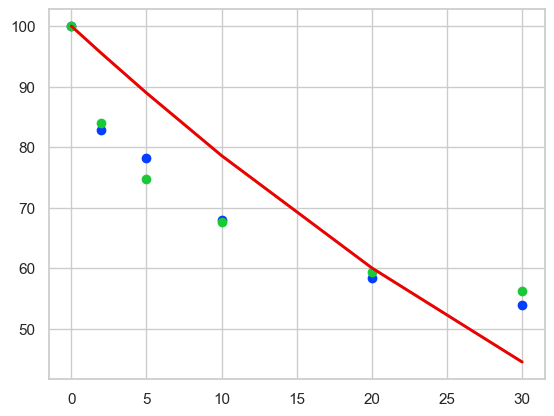

In [26]:
params = init_params(data_mutant, data_time)
modeling(data_mutant, data_time, params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 12
    # variables        = 2
    chi-square         = 2818.88941
    reduced chi-square = 281.888941
    Akaike info crit   = 69.5102993
    Bayesian info crit = 70.4801126
[[Variables]]
    vmax:  5.47509016 +/- 7.90580755 (144.40%) (init = 16.5)
    Km:    99.9999998 +/- 33.8059471 (33.81%) (init = 65.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = 0.992
[ 0.  2.  5. 10. 20. 30.]
[ 0.  2.  5. 10. 20. 30.]


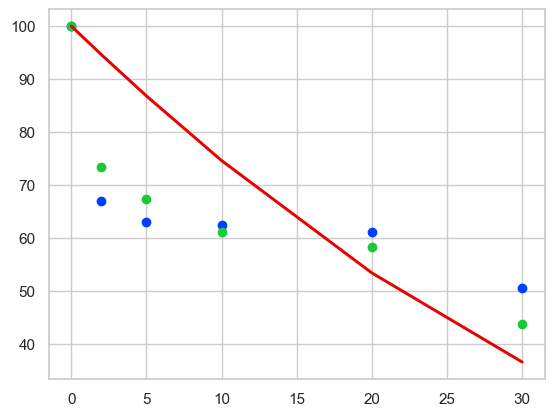

In [27]:
params = init_params(data_wildtype_with_c8, data_time)
modeling(data_wildtype_with_c8, data_time, params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 12
    # variables        = 2
    chi-square         = 1473.19869
    reduced chi-square = 147.319869
    Akaike info crit   = 61.7234157
    Bayesian info crit = 62.6932290
[[Variables]]
    vmax:  14.1107154 +/- 10.7178119 (75.96%) (init = 14.75)
    Km:    99.9999995 +/- 71.3470891 (71.35%) (init = 34)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = -0.985
[ 0.  2.  5. 10. 20. 30.]
[ 0.  2.  5. 10. 20. 30.]


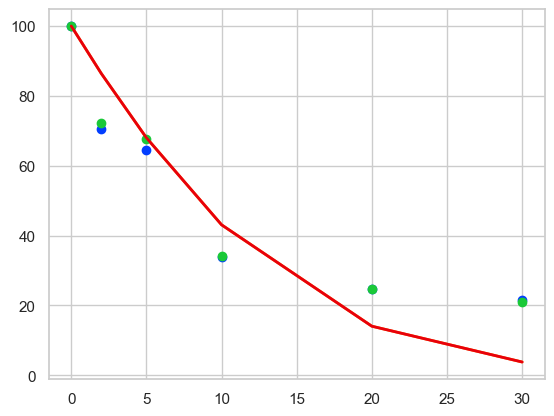

In [28]:
params = init_params(data_mutant_with_c8, data_time)
modeling(data_mutant_with_c8, data_time, params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 6
    # variables        = 2
    chi-square         = 727.214148
    reduced chi-square = 181.803537
    Akaike info crit   = 32.7847692
    Bayesian info crit = 32.3682881
[[Variables]]
    vmax:  17.0128696 +/- 39.5960937 (232.74%) (init = 20)
    Km:    129.999999 +/- 114.217134 (87.86%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = -0.996


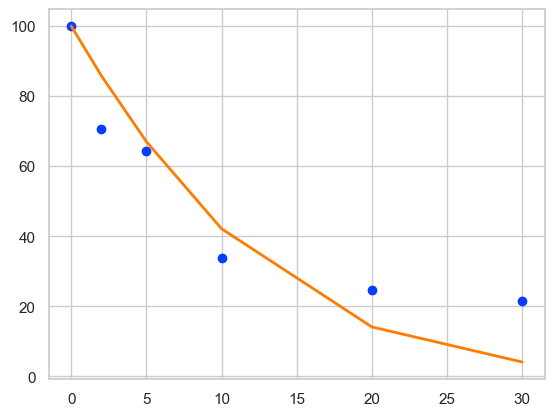

In [29]:
params = init_params(data_mutant_with_c8[0], data_time)
params['Km'].value = 100
params['Km'].min = 5
params['Km'].max = 130
params['vmax'].value = 20
params['vmax'].min = 10
params['vmax'].max = 25
modeling(data_mutant_with_c8[0], data_time, params)

In [30]:
import pyenzymekinetics as pk

In [31]:
data_new

array([[100. ,  90.4,  88.1,  88.6,  87.5,  82.8],
       [100. ,  88.5,  88.1,  87.7,  85.4,  83.9],
       [100. ,  82.9,  78.2,  67.9,  58.4,  54. ],
       [100. ,  83.9,  74.8,  67.6,  59.3,  56.2],
       [100. ,  67. ,  62.9,  62.4,  61.1,  50.5],
       [100. ,  73.4,  67.4,  61.1,  58.3,  43.6],
       [100. ,  70.5,  64.4,  33.9,  24.7,  21.6],
       [100. ,  72.1,  67.7,  34.1,  24.6,  21. ]])

In [32]:
data_mutant = np.array([data_new[2], data_new[3], data_new[6], data_new[7]])
data_mutant

array([[100. ,  82.9,  78.2,  67.9,  58.4,  54. ],
       [100. ,  83.9,  74.8,  67.6,  59.3,  56.2],
       [100. ,  70.5,  64.4,  33.9,  24.7,  21.6],
       [100. ,  72.1,  67.7,  34.1,  24.6,  21. ]])

Enzyme: 30 mg and 200 ul Vessel

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 24
    # variables        = 2
    chi-square         = 7024.92222
    reduced chi-square = 319.314646
    Akaike info crit   = 140.299974
    Bayesian info crit = 142.656082
[[Variables]]
    vmax:  7.60439283 +/- 23.1322387 (304.20%) (init = 14.75)
    Km:    99.9999929 +/- 476.591337 (476.59%) (init = 50.875)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = 0.999
[ 0.  2.  5. 10. 20. 30.]
[ 0.  2.  5. 10. 20. 30.]
[ 0.  2.  5. 10. 20. 30.]
[ 0.  2.  5. 10. 20. 30.]


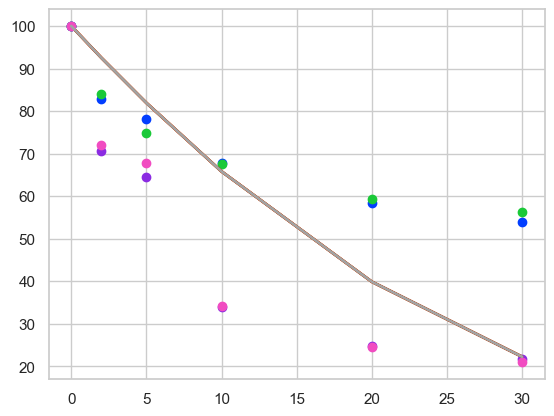

In [37]:
params = init_params(data_mutant, data_time)
modeling(data_mutant, data_time, params)